# Einsum decomposition

This notebook shows a way to decompose [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) into a subset of operations (expand_dims, squeeze, transpose, extended matrix multiplication).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Operator explanation with equation `bac,cd,def=ebc`

The operator einsum takes an equation and some inputs. Every letter involved in the equation is a loop. Let's see on one example.

In [3]:
import numpy

m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

equation = "bac,cd,def->ebc"
truth = numpy.einsum(equation, m1, m2, m3)
truth

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

This summation is equalent to:

In [4]:
res = numpy.zeros((2, 2, 2))
for a in range(0, 2):
    for b in range(0, 2):
        for c in range(0, 2):
            for d in range(0, 2):
                for e in range(0, 2):
                    for f in range(0, 2):
                        res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
res

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]])

Theoritically, this summation is in this case has a cost of $O(N^6)$. However this simple computation is usually much longer than using matrix multiplications along the path. $O(N^4)$ is the cost of the heaviest matrix multiplication in this case). But to do that, the equation needs to be decomposed into a sequence of matrix multiplications.

### Decomposition of `bac,cd,def=ebc`

In [5]:
import numpy
from mlprodict.testing.einsum import (
    decompose_einsum_equation, apply_einsum_sequence)

In [6]:
m1 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 10
m2 = numpy.arange(0, 4).astype(numpy.float32).reshape((2, 2)) + 100
m3 = numpy.arange(0, 8).astype(numpy.float32).reshape((2, 2, 2)) + 1000

In [7]:
seq = decompose_einsum_equation("bac,cd,def->ebc")

In [8]:
from jyquickhelper import RenderJsDot
RenderJsDot(seq.to_dot(size=7))

Then the result can be obtained as follows:

In [9]:
apply_einsum_sequence(seq, m1, m2, m3)

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### operator matmul

This operator can be used to represent either a multiplication, either a matrix multiplication but it applies only on arrays with the same number of dimensions. It can be broken into multiplication of matrix multiplication.

In [10]:
seq_clean = decompose_einsum_equation("bac,cd,def->ebc", strategy='numpy', clean=True)
RenderJsDot(seq_clean.to_dot(size=7))

Operator *transpose_mm* is a regular transposition, it takes two inputs but only tranposes the first input before returning it. Operator *batch_dot* is a matrix multiplication. It is left that way on purpose as it may be implemented with function dot or gemm. The operator distinguishes between 3 kind of axes: batch axes, kept axes, sum(mation) axes. It then reshapes both input matrices with 3D tensors, batch axis, row axis, column axis to use function [numpy.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html).

### ONNX

The previous graph can be converted into ONNX.

In [11]:
onx = seq_clean.to_onnx("Y", "X1", "X2", "X3", dtype=numpy.float32)
# with open("einsum.onnx", "wb") as f:
#      f.write(onx.SerializeToString())
%onnxview onx 

In [12]:
from onnxruntime import InferenceSession
sess = InferenceSession(onx.SerializeToString())
sess.run(None, {'X1': m1.astype(numpy.float32), 
                'X2': m2.astype(numpy.float32), 
                'X3': m3.astype(numpy.float32)})[0]

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### onnxruntime

In [13]:
import onnx
from onnx import helper, numpy_helper
from onnxruntime import InferenceSession


def make_model1(equation):
    model = helper.make_model(
        opset_imports=[helper.make_operatorsetid('', 13)],
        graph=helper.make_graph(
            name='einsum_test',
            inputs=[helper.make_tensor_value_info("X", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Y", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Z", onnx.TensorProto.FLOAT, None)],
            outputs=[helper.make_tensor_value_info("A", onnx.TensorProto.FLOAT, None)],
            nodes=[
                helper.make_node("Einsum", ["X", "Y", "Z"], ["A"], equation=equation)
            ]
        )
    )
    return model


model = make_model1("bac,cd,def->ebc")
sess = InferenceSession(model.SerializeToString())

In [14]:
sess.run(None, {'X': m1.astype(numpy.float32), 
                'Y': m2.astype(numpy.float32), 
                'Z': m3.astype(numpy.float32)})[0]

array([[[ 8866198.,  9864696.],
        [12090270., 13152928.]],

       [[ 8883886.,  9884376.],
        [12114390., 13179168.]]], dtype=float32)

### Benchmark

It clearly shows the summation done with the basic algorithm is the slowest.

In [15]:
from mlprodict.onnxrt.validate.validate_helper import measure_time
from tqdm import tqdm
from pandas import DataFrame


def raw_product(m1, m2, m3):
    N = m1.shape[0]
    res = numpy.zeros((N, N, N))
    for a in range(0, N):
        for b in range(0, N):
            for c in range(0, N):
                for d in range(0, N):
                    for e in range(0, N):
                        for f in range(0, N):
                            res[e, b, c] += m1[b, a, c] * m2[c, d] * m3[d, e, f]
    return res


def benchmark0(equation):
    sess = None
    sess2 = None
    seq = None 
    seq2 = None 

    results = []
    for N in tqdm([2, 3, 4, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]):
        m1 = numpy.random.randn(N, N, N)
        m2 = numpy.random.randn(N, N)
        m3 = numpy.random.randn(N, N, N)

        if seq is None:
            seq = decompose_einsum_equation(equation, clean=True)
        if seq2 is None:
            seq2 = decompose_einsum_equation(equation, clean=True, strategy='numpy')
        if sess is None:
            model = make_model1(equation)
            sess = InferenceSession(model.SerializeToString())
        if sess2 is None:
            onx = seq2.to_onnx("Y", "X1", "X2", "X3", dtype=numpy.float32)
            sess2 = InferenceSession(onx.SerializeToString())

        res = measure_time(lambda x: numpy.einsum(equation, *x, optimize=True),
                           [m1, m2, m3],
                           repeat=10, number=10)

        res['name'] = "numpy.einsum"
        res["N"] = N
        results.append(res)

        if N <= 4:
            res = measure_time(lambda x: raw_product(*x),
                               [m1, m2, m3],
                               repeat=10, number=10)
            res['name'] = "raw_product"
            res["N"] = N
            results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                           [m1, m2, m3],
                           repeat=10, number=10)

        res['name'] = "custom_einsum"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                           [m1, m2, m3],
                           repeat=10, number=10)
        res['name'] = "dec-matmul"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                           [m1, m2, m3],
                           repeat=10, number=10)
        res['name'] = "dec-batch_dot"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1], 'Z': x[2]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=10, number=10)
        res['name'] = "ort-einsum"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1], 'X3': x[2]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=10, number=10)
        res['name'] = "ort-matmul"
        res["N"] = N
        results.append(res)    
    return DataFrame(results)

df = benchmark0("bac,cd,def->ebc")
df.tail()

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
100%|██████████| 14/14 [00:20<00:00,  1.47s/it]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
82,0.065132,0.001338,0.063801,0.068927,10,10,0.651318,custom_einsum,60
83,0.051615,0.001206,0.049987,0.053465,10,10,0.516154,dec-matmul,60
84,0.062689,0.003658,0.058949,0.073073,10,10,0.626888,dec-batch_dot,60
85,0.009917,0.000274,0.009737,0.010686,10,10,0.099166,ort-einsum,60
86,0.015518,0.001107,0.014413,0.018179,10,10,0.155178,ort-matmul,60


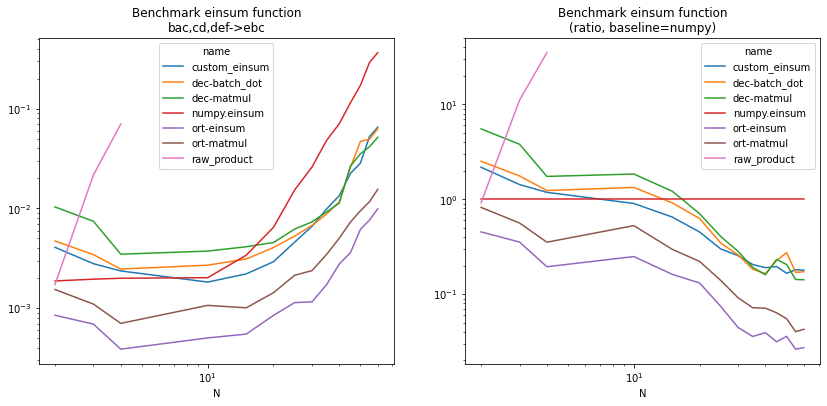

In [16]:
import matplotlib.pyplot as plt

piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function\nbac,cd,def->ebc")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

Version `dec-matmul` is an implementation based on the decomposition of a simplified einsum into a sequence of transpose, reshape, (batch_)dot or mul operations. This decomposition is converted into ONNX and executed with *onnxruntime*, version `ort-matmul`. Both versions are faster than the numpy optimized version.

## Another example with `bsnh,btnh=bnts`

Another case, more frequent in deep learning.

### Decomposition of `bsnh,btnh=bnts`

In [17]:
seq2 = decompose_einsum_equation("bsnh,btnh->bnts", strategy='numpy', clean=True)
RenderJsDot(seq2.to_dot(size=7))

### ONNX version

In [18]:
onx2 = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
%onnxview onx2 

### Benchmark

In [19]:
def make_model2(equation):
    model = helper.make_model(
        opset_imports=[helper.make_operatorsetid('', 13)],
        graph=helper.make_graph(
            name='einsum_test',
            inputs=[helper.make_tensor_value_info("X", onnx.TensorProto.FLOAT, None),
                    helper.make_tensor_value_info("Y", onnx.TensorProto.FLOAT, None)],
            outputs=[helper.make_tensor_value_info("A", onnx.TensorProto.FLOAT, None)],
            nodes=[
                helper.make_node("Einsum", ["X", "Y"], ["A"], equation=equation)
            ]
        )
    )
    return model


def benchmark(equation, second_input_size=4):
    sess = None
    sess2 = None
    seq = None
    seq2 = None


    results = []
    for N in tqdm([2, 3, 4, 10, 20, 30, 40]):
        m1 = numpy.random.randn(10, N, N, N)
        m2 = numpy.random.randn(10 * N ** (second_input_size-1)).reshape((10, ) + (N, ) * (second_input_size-1))
        

        if seq is None:
            seq = decompose_einsum_equation(equation, clean=True)
        if seq2 is None:
            seq2 = decompose_einsum_equation(equation, clean=True, strategy='numpy')
        if sess is None:
            model = make_model2(equation)
            sess = InferenceSession(model.SerializeToString())
        if sess2 is None:
            onx = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
            sess2 = InferenceSession(onx.SerializeToString())

        res = measure_time(lambda x: numpy.einsum(equation, *x, optimize=True),
                           [m1, m2],
                           repeat=10, number=10)

        res['name'] = "numpy.einsum"
        res["N"] = N
        results.append(res)

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                           [m1, m2],
                           repeat=10, number=10)
        res['name'] = "custom_einsum"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                           [m1, m2],
                           repeat=10, number=10)
        res['name'] = "dec-matmul"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                           [m1, m2],
                           repeat=10, number=10)
        res['name'] = "dec-batch_dot"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=10, number=10)
        res['name'] = "ort-einsum"
        res["N"] = N
        results.append(res)    

        res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=10, number=10)
        res['name'] = "ort-matmul"
        res["N"] = N
        results.append(res)    
    return DataFrame(results)


df = benchmark("bsnh,btnh->bnts")
df.tail()

100%|██████████| 7/7 [00:13<00:00,  1.93s/it]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
37,0.229418,0.020792,0.217997,0.291032,10,10,2.294175,custom_einsum,40
38,0.160575,0.005435,0.150772,0.167411,10,10,1.605746,dec-matmul,40
39,0.112844,0.011305,0.102173,0.141890,10,10,1.128436,dec-batch_dot,40
40,0.051181,0.003533,0.047244,0.057054,10,10,0.511815,ort-einsum,40
41,0.078827,0.008735,0.067893,0.099156,10,10,0.788271,ort-matmul,40


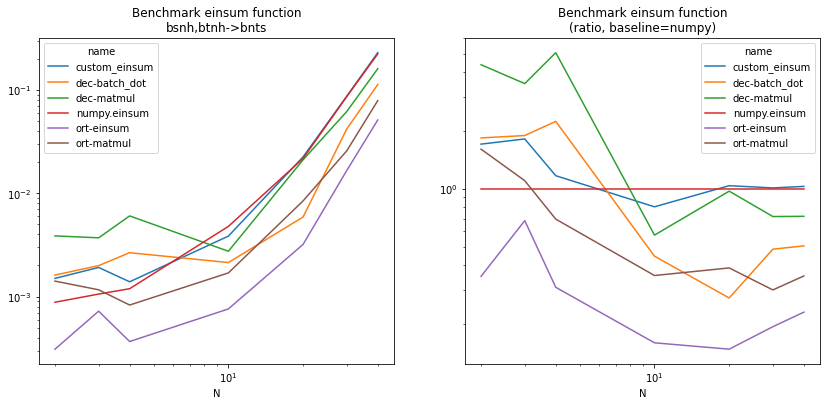

In [20]:
piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function\nbsnh,btnh->bnts")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

### Permutation

Einsum's algorithm started by aligning all matrices involved in the computation to the same dimension in the same order. But which order is the best, that's the question.

In [21]:
equation = "bsnh,btnh->bnts"
letters = list(sorted(set([c for c in equation if "a" <= c < "z"])))
letters

['b', 'h', 'n', 's', 't']

In [22]:
from itertools import permutations


def benchmark_perm(equation, number=5, second_input_size=4, repeat=3, N=15):
    
    def n_operator(seq, name):
        n = 0
        for op in seq:
            if op.name == name:
                n += 1
        return n


    def n_onnx_op(onx, name):
        n = 0
        for op in onx.graph.node:
            if op.op_type == name:
                n += 1
        return n


    def get_kind(seq):
        n = 0
        for op in seq:
            if op.name == 'batch_dot':
                return op.get_dot_kind()
        return None


    m1 = numpy.random.randn(N, N, N, N)
    m2 = numpy.random.randn(N ** second_input_size).reshape((N, ) * second_input_size)

    results = []
    for perm in tqdm(list(permutations(letters))):
        replace = {d: c for c, d in zip(letters, perm)}
        eq = equation
        for k, v in replace.items():
            eq = eq.replace(k, v.upper())
        eq = eq.lower()

        seq = decompose_einsum_equation(eq, clean=True)
        seq2 = decompose_einsum_equation(eq, clean=True, strategy='numpy')
        model = make_model2(eq)
        sess = InferenceSession(model.SerializeToString())
        onx = seq2.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
        sess2 = InferenceSession(onx.SerializeToString())

        n_tra = n_operator(seq2, 'transpose')
        n_tra_onnx = n_onnx_op(onx, 'Transpose')
        n_gemm_onnx = n_onnx_op(onx, 'Gemm')
        kind = get_kind(seq2)

        res = measure_time(lambda x: numpy.einsum(eq, *x, optimize=True),
                           [m1, m2],
                           repeat=repeat, number=number)

        res['name'] = "numpy.einsum"
        res["N"] = N
        res["eq"] = eq
        results.append(res)

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x),
                           [m1, m2],
                           repeat=repeat, number=number)
        res['name'] = "custom_einsum"
        res["N"] = N
        res["eq"] = eq
        res['transpose'] = n_tra
        res['kind'] = kind
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq, *x, matmul_impl="pyf"),
                           [m1, m2],
                           repeat=repeat, number=number)
        res['name'] = "dec-matmul"
        res["N"] = N
        res["eq"] = eq
        res['transpose'] = n_tra
        res['kind'] = kind
        results.append(res)    

        res = measure_time(lambda x: apply_einsum_sequence(seq2, *x, matmul_impl="pyf"),
                           [m1, m2],
                           repeat=repeat, number=number)
        res['name'] = "dec-batch_dot"
        res["N"] = N
        res["eq"] = eq
        res['transpose'] = n_tra
        res['kind'] = kind
        results.append(res)    

        res = measure_time(lambda x: sess.run(None, {'X': x[0], 'Y': x[1]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=repeat, number=number)
        res['name'] = "ort-einsum"
        res["N"] = N
        res["eq"] = eq
        res['transpose'] = n_tra_onnx
        res['gemm'] = n_gemm_onnx
        results.append(res)    

        res = measure_time(lambda x: sess2.run(None, {'X1': x[0], 'X2': x[1]}),
                           [m1.astype(numpy.float32), m2.astype(numpy.float32),
                            m3.astype(numpy.float32)],
                           repeat=repeat, number=number)
        res['name'] = "ort-matmul"
        res["N"] = N
        res["eq"] = eq
        res['transpose'] = n_tra_onnx
        res['gemm'] = n_gemm_onnx
        results.append(res)    
    return DataFrame(results)


df = benchmark_perm("bsnh,btnh->bnts", number=4)
df.tail()

100%|██████████| 120/120 [00:11<00:00, 10.23it/s]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq,transpose,kind,gemm
715,0.006162,0.000038,0.006128,0.006216,3,4,0.018485,custom_einsum,15,"thns,tbns->tnbh",3.0,NN,NaN
716,0.002343,0.000046,0.002294,0.002405,3,4,0.007029,dec-matmul,15,"thns,tbns->tnbh",3.0,NN,NaN
717,0.001645,0.000035,0.001610,0.001694,3,4,0.004934,dec-batch_dot,15,"thns,tbns->tnbh",3.0,NN,NaN
718,0.000833,0.000015,0.000820,0.000853,3,4,0.002498,ort-einsum,15,"thns,tbns->tnbh",4.0,NaN,0.0
719,0.001251,0.000012,0.001238,0.001268,3,4,0.003753,ort-matmul,15,"thns,tbns->tnbh",4.0,NaN,0.0


In [23]:
df = df.sort_values("average").reset_index(drop=True)
df.head()

,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq,transpose,kind,gemm
0,0.000758,0.000015,0.000738,0.000771,3,4,0.002275,ort-matmul,15,"hsnt,hbnt->hnbs",4.0,NaN,0.0
1,0.000770,0.000023,0.000739,0.000793,3,4,0.002310,ort-matmul,15,"hnts,hbts->htbn",4.0,NaN,0.0
2,0.000778,0.000020,0.000758,0.000806,3,4,0.002334,ort-matmul,15,"bnst,bhst->bshn",4.0,NaN,0.0
3,0.000783,0.000021,0.000760,0.000812,3,4,0.002350,ort-matmul,15,"bnht,bsht->bhsn",4.0,NaN,0.0
4,0.000784,0.000011,0.000774,0.000799,3,4,0.002351,ort-matmul,15,"hnst,hbst->hsbn",4.0,NaN,0.0


In [24]:
df.tail()

,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq,transpose,kind,gemm
715,0.011529,0.000882,0.010456,0.012617,3,4,0.034587,custom_einsum,15,"sbnt,shnt->snhb",3.0,NN,NaN
716,0.011548,0.000422,0.010967,0.011953,3,4,0.034644,custom_einsum,15,"htsb,hnsb->hsnt",3.0,NN,NaN
717,0.013971,0.001984,0.012279,0.016754,3,4,0.041912,custom_einsum,15,"nbsh,ntsh->nstb",3.0,NN,NaN
718,0.014765,0.001483,0.013366,0.016818,3,4,0.044295,numpy.einsum,15,"bnsh,btsh->bstn",NaN,NaN,NaN
719,0.015813,0.002921,0.012546,0.019636,3,4,0.047438,numpy.einsum,15,"nbsh,ntsh->nstb",NaN,NaN,NaN


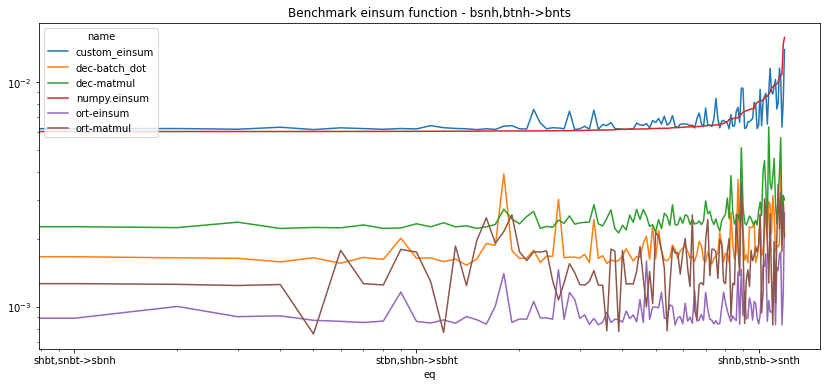

In [25]:
piv = df.pivot("eq", "name", "average").sort_values("numpy.einsum")
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax)
ax.set_title("Benchmark einsum function - bsnh,btnh->bnts");

In [26]:
set(df['transpose'].dropna()), set(df['gemm'].dropna()), set(df['kind'].dropna())

({3.0, 4.0}, {0.0}, {'NN'})

## Decomposition of `bsnh,ctnh=nts`

In [27]:
seq3 = decompose_einsum_equation("bsnh,ctnh->nts", strategy='numpy', clean=True)
RenderJsDot(seq3.to_dot(size=7))

In [28]:
onx3 = seq3.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
%onnxview onx3

### Benchmark size

In [29]:
df = benchmark("bsnh,ctnh->nts")
df.tail()

100%|██████████| 7/7 [00:39<00:00,  5.71s/it]


,average,deviation,min_exec,max_exec,repeat,number,total,name,N
37,0.043389,0.016879,0.030195,0.077480,10,10,0.433885,custom_einsum,40
38,0.015310,0.000222,0.014909,0.015622,10,10,0.153098,dec-matmul,40
39,0.013508,0.000425,0.013148,0.014576,10,10,0.135085,dec-batch_dot,40
40,0.032725,0.000266,0.032409,0.033212,10,10,0.327254,ort-einsum,40
41,0.057384,0.002703,0.053734,0.062845,10,10,0.573841,ort-matmul,40


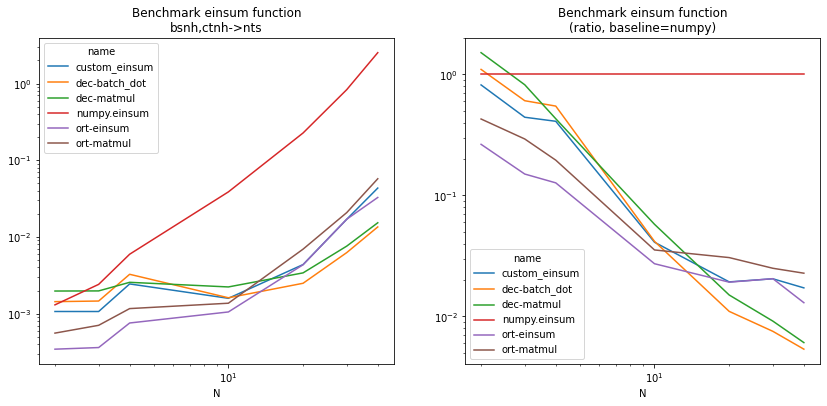

In [30]:
piv = df.pivot("N", "name", "average")
piv2 = piv.copy()
np = piv["numpy.einsum"]
for c in piv2.columns:
    piv2[c] /= np
    
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax[0])
ax[0].set_title("Benchmark einsum function\nbsnh,ctnh->nts")
piv2.plot(logy=True, logx=True, ax=ax[1])
ax[1].set_title("Benchmark einsum function\n(ratio, baseline=numpy)");

### Benchmark permutation

In [34]:
df = benchmark_perm("bsnh,ctnh->nts", number=2, repeat=3, N=10)

100%|██████████| 120/120 [00:06<00:00, 17.41it/s]


In [35]:
df = df.sort_values("average").reset_index(drop=True)
df.head()

,average,deviation,min_exec,max_exec,repeat,number,total,name,N,eq,transpose,kind,gemm
0,0.000125,0.000008,0.000118,0.000136,3,2,0.000374,ort-matmul,10,"bnst,chst->shn",4.0,NaN,0.0
1,0.000126,0.000007,0.000119,0.000136,3,2,0.000377,ort-matmul,10,"bhst,cnst->snh",4.0,NaN,0.0
2,0.000141,0.000006,0.000136,0.000150,3,2,0.000422,ort-matmul,10,"hbst,cnst->snb",5.0,NaN,0.0
3,0.000141,0.000007,0.000135,0.000151,3,2,0.000423,ort-matmul,10,"nbst,chst->shb",5.0,NaN,0.0
4,0.000144,0.000007,0.000138,0.000154,3,2,0.000432,ort-matmul,10,"btns,chns->nht",5.0,NaN,0.0


In [36]:
set(df['transpose'].dropna()), set(df['gemm'].dropna()), set(df['kind'].dropna())

({3.0, 4.0, 5.0, 6.0}, {0.0}, {'NN'})

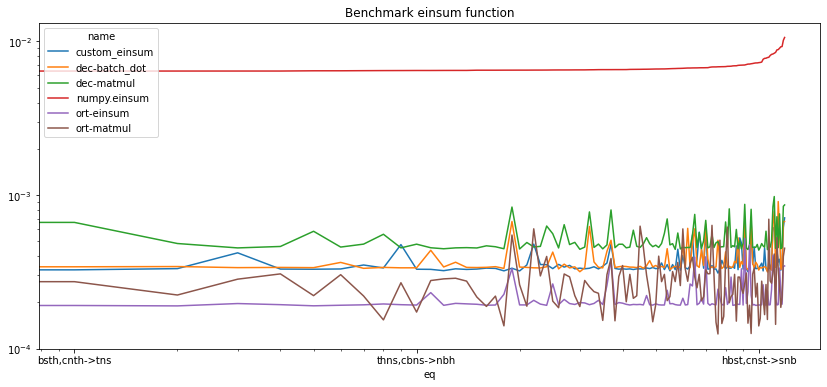

In [37]:
piv = df.pivot("eq", "name", "average").sort_values("numpy.einsum")
    
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
piv.plot(logy=True, logx=True, ax=ax)
ax.set_title("Benchmark einsum function");

### Best permutation

One of the best permutation is `bnst,chst->shn`.

In [38]:
seq4 = decompose_einsum_equation("bnst,chst->shn", strategy='numpy', clean=True)
RenderJsDot(seq4.to_dot(size=7))

In [39]:
onx4 = seq4.to_onnx("Y", "X1", "X2", dtype=numpy.float32)
%onnxview onx4